### to tidy up the week 2 code, turn it into nice functions

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' #make sure I'm using the right GPU

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import uproot as ur
import pandas as pd
import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

plotpath = '/home/kaelaekd/start_tf/LCStudies/clusters/Plots/'

import sys
sys.path.append('/home/kaelaekd/start_tf/LCStudies')
from  util import resolution_util as ru
from  util import plot_util as pu

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

In [3]:
# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4] #'image sizes' in phi/eta coords
len_eta = [128, 16, 8, 4, 4, 2]

path = '/fast_scratch/atlas_images/v7/'

branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']

In [4]:
p0_file = ur.open(path+'pi0.root')
p0_tree = p0_file['ClusterTree']
p0 = pd.DataFrame(p0_tree.arrays(expressions = branches, library='np'))

pp_file = ur.open(path+'piplus.root')
pp_tree = pp_file['ClusterTree']
pp = pd.DataFrame(pp_tree.arrays(expressions = branches, library='np')) 

pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT 
p0['clusterEoverCalib'] = p0.clusterE / p0.cluster_ENG_CALIB_TOT

In [5]:
def simple_pi_NN(ppdat_list, p0dat_list, epochs):
    """ Run a simple neural network to distinguish between pi+ and pi0 based on variable input data (ppdat_list
    and p0dat_list) for a given number of training epochs.
    the lists need to be lists of data arrays or dataframe objs - the actual data to be used
    (see run below)
    formats the data, makes the model, trains and tests the model. returns the training history and some
    metrics (change to include other metrics if needed)"""
    
    dim = len(ppdat_list) #get the data dimensions
    
    #define metrics to return
    METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        #tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        #tf.keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve
    ]
    
    #format data and labels
    ppdat = np.column_stack(ppdat_list) 
    p0dat = np.column_stack(p0dat_list)
    dataset = np.append(ppdat, p0dat, axis=0)
    labels = np.append(np.zeros(len(ppdat_list[0])), np.ones(len(p0dat_list[0])))#0 = pp, 1 = p0
    
    print(ppdat.shape, dataset.shape, labels.shape)
    
    #split into training and testing sets
    data_train, data_test, label_train, label_test = train_test_split(dataset, labels, test_size=0.3, random_state=1)
    
    #need to one hot the labels!
    label_train_oh = np_utils.to_categorical(label_train, 2)
    label_test_oh = np_utils.to_categorical(label_test, 2)
    
    print(label_train.shape, label_train_oh.shape, label_train_oh[0])
    
    #define model
    #seems to actually perform better without too many nodes
    model = tf.keras.Sequential([tf.keras.layers.Dense(30, activation='relu', input_dim=dim),
                                 #tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(30, activation='relu'),
                                 tf.keras.layers.Dense(30, activation='relu'),
                                 tf.keras.layers.Dense(2, kernel_initializer='normal', activation='softmax')]) #needed to specify softmax on last layer (why?)
    
    #compile model
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #can't be sparse if using onehot!
                  metrics=METRICS)
    
    #train the model
    history = model.fit(data_train, label_train_oh, epochs=epochs)
    
    print('\n test accuracy:')
    #evaluate it on the test data
    test_results = model.evaluate(data_test,  label_test_oh, verbose=2)
    
    #get some metrics using the test data
    score = model.predict(data_test)
    fpr_pred, tpr_pred, _ = roc_curve(label_test_oh[:,1], score[:,1],drop_intermediate=False)
    auc_pred = auc(fpr_pred, tpr_pred)
    
    return history, fpr_pred, tpr_pred, auc_pred

In [6]:
ppdatlist = (pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG, pp.clusterE)
p0datlist = (p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG, p0.clusterE)
#need this format for the way my function is set up :)

In [14]:
def metrics_and_plots(hist, FPR, TPR, AUC):
    """ plots training accuracy and loss, an ROC curve, prints out the AUC of the curve, plots how auc changed
    with epoch while training, makes a rejection/efficiency plot, and prints out the rejection at 95% pion 
    efficiency"""
    
    # plot training accuracy
    plt.figure(figsize=[6,6])
    plt.xlim(-.1,len(hist.history['loss']))
    plt.plot(hist.history['accuracy'], label='training accuracy', c='xkcd:orange', linewidth=3) #I think this is all the history object keeps, plus val stuff but idk about that yet
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('./Plots/train_acc')

    # plot loss during training
    plt.figure(figsize=[6,6])
    plt.xlim(-.1,len(hist.history['loss']))
    plt.ylim(0.4, .6)
    plt.semilogy()
    plt.plot(hist.history['loss'], label = 'training loss', c='xkcd:apricot', linewidth=4) #it keeps the other metrics I sent it too!! sweeeeeeeettt!!!!!!!!
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig('./Plots/train_loss')
    
    #roc curve
    plt.figure(figsize=[6,6])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot(FPR, TPR, c='xkcd:sepia', linewidth=3)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate') 
    plt.savefig('./Plots/ROC1')
    
    print('AUC:', AUC)
    
    #rejection/efficiency plot
    plt.figure(figsize=[6,6])
    plt.xlim(0,1)
    plt.semilogy()
    plt.ylim(0, 1.4e5)
    plt.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
    plt.xlabel('Efficiency (tpr)') 
    plt.ylabel('Rejection (1/fpr)')
    plt.savefig('./Plots/effrej.pdf')
    
    f = interp1d(TPR, 1/FPR)
    
    print('Rejection at 95% efficiency:', f(.95))
    
    #plot auc while training
    plt.figure(figsize=[6,6])
    plt.xlim(0,len(hist.history['auc']))
    plt.plot(hist.history['auc'], c='xkcd:clay brown', linewidth=3)
    plt.xlabel('epoch')
    plt.ylabel('training auc')

(435967, 3) (699858, 3) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/30
15310/15310 [==============================] - 105s 7ms/step - loss: 0.6195 - tp: 172311.4260 - fp: 72680.5693 - tn: 172311.4260 - fn: 72680.5693 - accuracy: 0.6859 - precision: 0.6859 - auc: 0.7689
Epoch 2/30
15310/15310 [==============================] - 106s 7ms/step - loss: 0.4525 - tp: 189709.3725 - fp: 55282.6228 - tn: 189709.3725 - fn: 55282.6228 - accuracy: 0.7722 - precision: 0.7722 - auc: 0.8676
Epoch 3/30
15310/15310 [==============================] - 105s 7ms/step - loss: 0.4344 - tp: 191365.6250 - fp: 53626.3703 - tn: 191365.6250 - fn: 53626.3703 - accuracy: 0.7811 - precision: 0.7811 - auc: 0.8776
Epoch 4/30
15310/15310 [==============================] - 105s 7ms/step - loss: 0.4279 - tp: 192320.9886 - fp: 52671.0067 - tn: 192320.9886 - fn: 52671.0067 - accuracy: 0.7846 - precision: 0.7846 - auc: 0.8800
Epoch 5/30
15310/15310 [==============================] - 104s 7ms/step - loss: 0.4211 - tp: 193

<ipython-input-9-c559d1d6eae3>:35: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1.4e5)
<ipython-input-9-c559d1d6eae3>:36: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)


Rejection at 95% efficiency: 2.696747894094624


<ipython-input-9-c559d1d6eae3>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


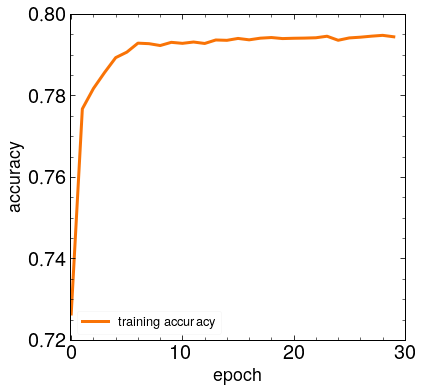

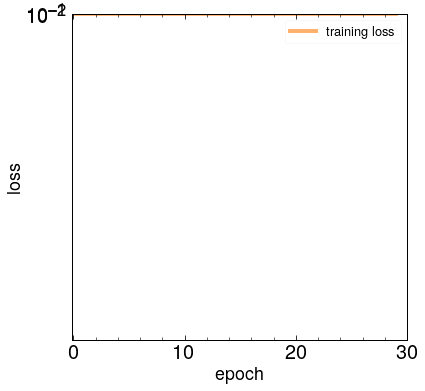

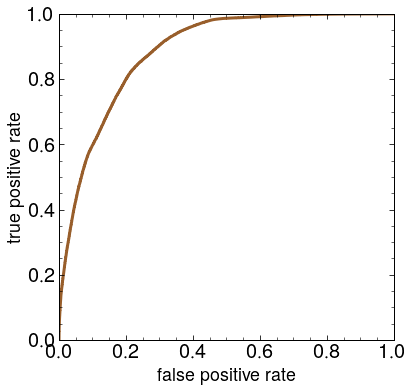

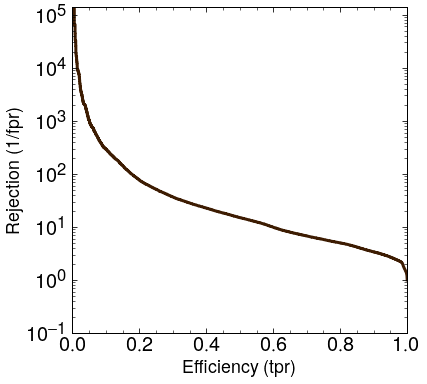

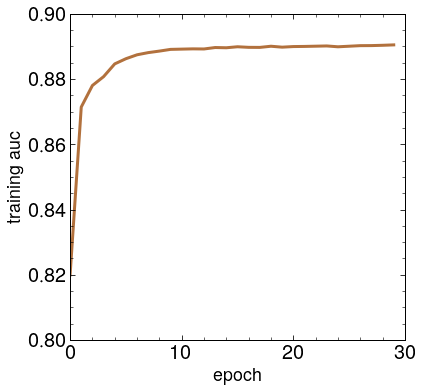

In [10]:
hist, FPR, TPR, AUC = simple_pi_NN(ppdatlist, p0datlist, epochs=30) 

metrics_and_plots(hist, FPR, TPR, AUC) #whoops, wrong loss plot

AUC: 0.8852644546905665


<ipython-input-11-109a3209037a>:35: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1.4e5)
<ipython-input-11-109a3209037a>:36: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)


Rejection at 95% efficiency: 2.696747894094624


<ipython-input-11-109a3209037a>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


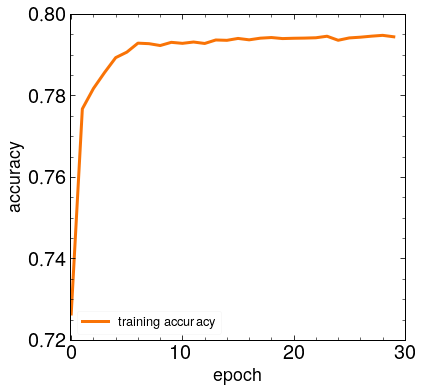

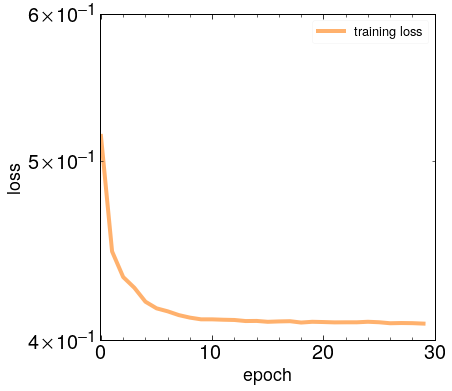

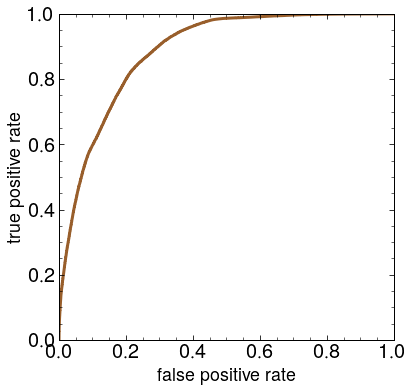

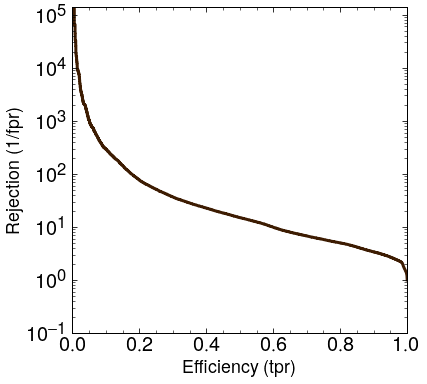

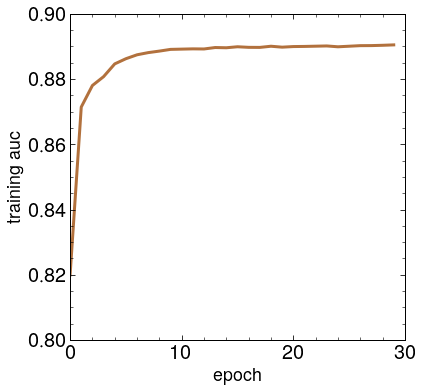

In [12]:
metrics_and_plots(hist, FPR, TPR, AUC)